# Import

In [1]:
%cd ..

/Users/ruasvmv/PycharmProjects/super_resolution


In [2]:
# !python3.9 -m pip install -r requirements.txt

In [3]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [4]:
from src.features.build_dataset import DatasetFromFolder
from src.features.build_dataset import calculate_valid_crop_size
from src.features.build_dataset import input_transform
from src.features.build_dataset import target_transform

In [5]:
from src.data.data_load import download_bsd300

In [6]:
from src.models.train_model import train, test, checkpoint

# Config

# Code

In [7]:
class RGBDatasetFromFolder(DatasetFromFolder):
    def __getitem__(self, item):
        input = self.load_image(self.image_filenames[item])
        target = input.copy()
        if self.input_transform:
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)
        return input, target
    
    def load_image(self, filepath: str):
        img = Image.open(filepath)
        return img

In [8]:
def get_training_set(upscale_factor):
    root_dir = download_bsd300()
    train_dir = os.path.join(root_dir, "train")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return RGBDatasetFromFolder(train_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))


def get_test_set(upscale_factor):
    root_dir = download_bsd300()
    test_dir = os.path.join(root_dir, "test")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return RGBDatasetFromFolder(test_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))

In [9]:
class SRCNN(nn.Module):
    def __init__(self, upscale_factor):
        super(SRCNN, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, 3 * upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        nn.init.orthogonal_(self.conv1.weight, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.conv2.weight, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.conv3.weight, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.conv4.weight)

In [10]:
def super_resolve(input_filename: str, output_filename: str, model):
    img = Image.open(input_filename)

    img_to_tensor = ToTensor()
    input = img_to_tensor(img).view(1, -1, img.size[1], img.size[0])

    out = model(input)
    out = out.cpu()
    out_img_y = out[0].detach().numpy()
    out_img_y *= 255.0
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = Image.merge('RGB', 
                            [Image.fromarray(np.uint8(out_img_y[0])),
                             Image.fromarray(np.uint8(out_img_y[1])), 
                             Image.fromarray(np.uint8(out_img_y[2]))])

    out_img_y.save(output_filename)
    print('output image saved to ', output_filename)

In [11]:
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_set = get_training_set(upscale_factor=2)
    test_set = get_test_set(upscale_factor=2)

    batch_size = 32

    training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size,
                                      shuffle=True)
    testing_data_loader = DataLoader(dataset=test_set, num_workers=0, batch_size=batch_size,
                                     shuffle=False)

    model = SRCNN(upscale_factor=2).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1, 50):
        train(epoch, model, training_data_loader, criterion, optimizer, device)
        test(model, testing_data_loader, criterion, device)
        checkpoint(epoch, model, 'models')

    

===> Epoch[1](1/7): Loss: 0.3539
===> Epoch[1](2/7): Loss: 0.1568
===> Epoch[1](3/7): Loss: 0.1131
===> Epoch[1](4/7): Loss: 0.0640
===> Epoch[1](5/7): Loss: 0.0336
===> Epoch[1](6/7): Loss: 0.0350
===> Epoch[1](7/7): Loss: 0.0403
===> Epoch 1 Complete: Avg. Loss: 0.1138
===> Avg. PSNR: 15.4205 dB
Checkpoint saved to models/model_epoch_1.pth
===> Epoch[2](1/7): Loss: 0.0301
===> Epoch[2](2/7): Loss: 0.0274
===> Epoch[2](3/7): Loss: 0.0261
===> Epoch[2](4/7): Loss: 0.0207
===> Epoch[2](5/7): Loss: 0.0238
===> Epoch[2](6/7): Loss: 0.0207
===> Epoch[2](7/7): Loss: 0.0205
===> Epoch 2 Complete: Avg. Loss: 0.0242
===> Avg. PSNR: 17.2406 dB
Checkpoint saved to models/model_epoch_2.pth
===> Epoch[3](1/7): Loss: 0.0204
===> Epoch[3](2/7): Loss: 0.0179
===> Epoch[3](3/7): Loss: 0.0207
===> Epoch[3](4/7): Loss: 0.0176
===> Epoch[3](5/7): Loss: 0.0189
===> Epoch[3](6/7): Loss: 0.0171
===> Epoch[3](7/7): Loss: 0.0156
===> Epoch 3 Complete: Avg. Loss: 0.0183
===> Avg. PSNR: 18.3098 dB
Checkpoint sa

===> Epoch[24](6/7): Loss: 0.0032
===> Epoch[24](7/7): Loss: 0.0032
===> Epoch 24 Complete: Avg. Loss: 0.0031
===> Avg. PSNR: 25.1231 dB
Checkpoint saved to models/model_epoch_24.pth
===> Epoch[25](1/7): Loss: 0.0030
===> Epoch[25](2/7): Loss: 0.0034
===> Epoch[25](3/7): Loss: 0.0028
===> Epoch[25](4/7): Loss: 0.0030
===> Epoch[25](5/7): Loss: 0.0031
===> Epoch[25](6/7): Loss: 0.0027
===> Epoch[25](7/7): Loss: 0.0028
===> Epoch 25 Complete: Avg. Loss: 0.0030
===> Avg. PSNR: 25.1727 dB
Checkpoint saved to models/model_epoch_25.pth
===> Epoch[26](1/7): Loss: 0.0032
===> Epoch[26](2/7): Loss: 0.0030
===> Epoch[26](3/7): Loss: 0.0027
===> Epoch[26](4/7): Loss: 0.0034
===> Epoch[26](5/7): Loss: 0.0031
===> Epoch[26](6/7): Loss: 0.0027
===> Epoch[26](7/7): Loss: 0.0015
===> Epoch 26 Complete: Avg. Loss: 0.0028
===> Avg. PSNR: 25.1258 dB
Checkpoint saved to models/model_epoch_26.pth
===> Epoch[27](1/7): Loss: 0.0028
===> Epoch[27](2/7): Loss: 0.0031
===> Epoch[27](3/7): Loss: 0.0032
===> Epoc

===> Avg. PSNR: 26.2089 dB
Checkpoint saved to models/model_epoch_47.pth
===> Epoch[48](1/7): Loss: 0.0025
===> Epoch[48](2/7): Loss: 0.0027
===> Epoch[48](3/7): Loss: 0.0024
===> Epoch[48](4/7): Loss: 0.0021
===> Epoch[48](5/7): Loss: 0.0021
===> Epoch[48](6/7): Loss: 0.0025
===> Epoch[48](7/7): Loss: 0.0012
===> Epoch 48 Complete: Avg. Loss: 0.0022
===> Avg. PSNR: 26.2071 dB
Checkpoint saved to models/model_epoch_48.pth
===> Epoch[49](1/7): Loss: 0.0023
===> Epoch[49](2/7): Loss: 0.0023
===> Epoch[49](3/7): Loss: 0.0027
===> Epoch[49](4/7): Loss: 0.0023
===> Epoch[49](5/7): Loss: 0.0021
===> Epoch[49](6/7): Loss: 0.0021
===> Epoch[49](7/7): Loss: 0.0031
===> Epoch 49 Complete: Avg. Loss: 0.0024
===> Avg. PSNR: 26.2502 dB
Checkpoint saved to models/model_epoch_49.pth


In [12]:
super_resolve('mosaic.jpg', 'mosaic_x2.jpg', model)

output image saved to  mosaic_x2.jpg


In [13]:
super_resolve('test.jpg', 'out2.jpg', model)

output image saved to  out2.jpg


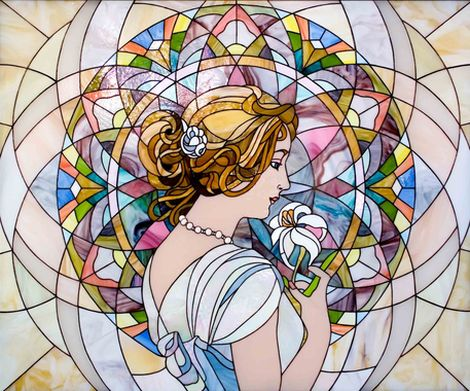

In [14]:
Image.open('mosaic.jpg')

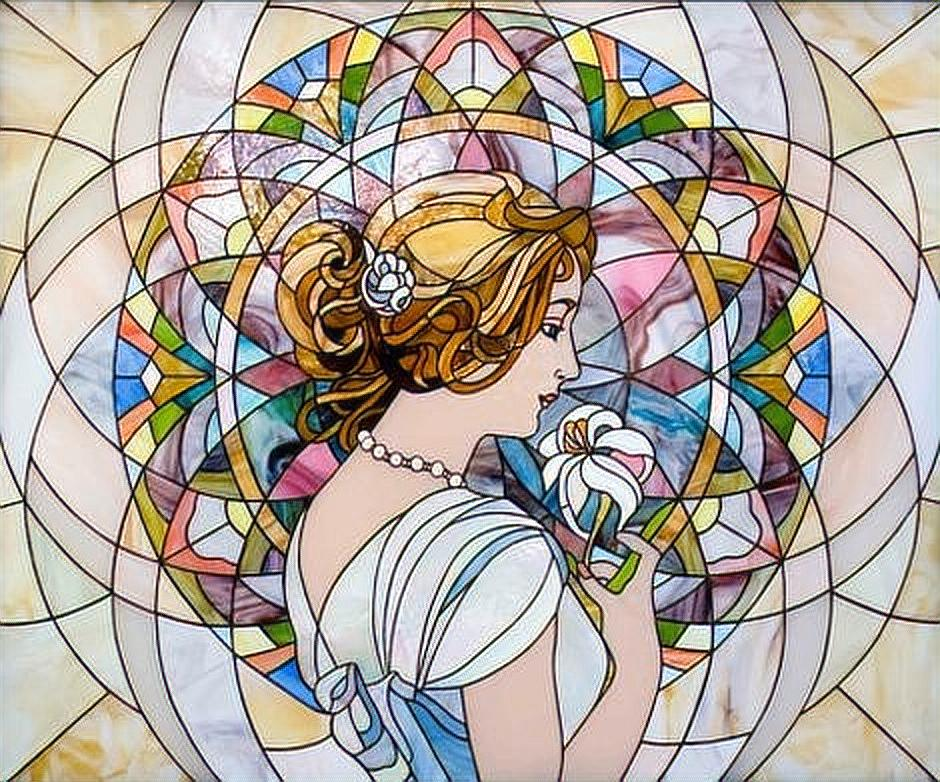

In [15]:
Image.open('mosaic_x2.jpg')